# Measuring the Mass-Ratio Distribution in Real Data
This notebook performs inference on my mass ratio data to estimate mass ratio distribution.

In [1]:
# Imports.
from __future__ import print_function, division, absolute_import

import pandas as pd
from kglib.utils import HelperFunctions, plottools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from astroquery.vizier import Vizier
import logging
from astropy.time import Time 
import seaborn as sns
sns.set_context('notebook', font_scale=1.5)
sns.set_style('white')

logger = logging.getLogger()
logger.setLevel(logging.WARN)
%matplotlib inline

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Pull out the mass ratio data and completess

In [2]:
from MassRatioDistribution import Hist
import h5py

In [3]:
# List the stars that I believe
good_hipnums = [100221, 100907, 103298, 10732, 109139, 109521, 115115, 12332, 12706, 
                13327, 14764, 16244, 16340, 19949, 20380, 21589, 22833, 22958,
                23362, 23916, 24902, 2548, 26126, 32607, 37322, 38593, 
                38846, 40881, 42129, 46283, 52678, 5310, 72154, 76267, 77336, 
                77516, 79404, 80460, 82673, 84606, 88116, 88817, 88818, 91118, 93805]
binary_starlist = ['HIP {}'.format(n) for n in good_hipnums]
binary_starlist.append('HR 545')

# Make a list of the more complicated multiple systems. Exclude for now, but maybe include later...
multiple_hipnums = [13165, 14576, 18724, 28691, 39847, 55266,
                    63948, 78820, 79199, 96840]
multiple_starlist = ['HIP {}'.format(n) for n in multiple_hipnums]
multiple_starlist.append('HR 604')

# Unconfirmed stars
unconfirmed_hipnums = [13327, 16340, 19949, 23362, 23916, 38846, 40881, 72154, 88817]
unconfirmed_starlist = ['HIP {}'.format(n) for n in unconfirmed_hipnums]

In [4]:
len(binary_starlist), len(multiple_starlist)

(46, 11)

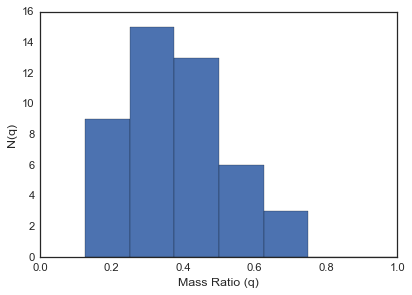

In [35]:
# Read in all of the mass ratio samples
prior_hdf5 = 'data/MassSamples.h5'
with h5py.File(prior_hdf5, 'r') as f:
    q_list = []
    stars = []
    for starname, star_grp in f.iteritems():
        if starname in binary_starlist and starname:
            M1 = star_grp['primary'].value
            M2_spt = star_grp['companion_spectral_type'].value
            M2_iso = star_grp['companion_isochrone'].value
            
            q_list.append(M2_iso / M1)
            stars.append(starname)
    
    maxsize = max(a.size for a in q_list)
    q = np.ones((len(q_list), maxsize)) * np.nan
    for i, qi in enumerate(q_list):
        q[i][:qi.size] = qi

mean_q = np.nanmedian(q, axis=1)
mean_q = mean_q[~np.isnan(mean_q)]
bins = np.linspace(0, 1.0, 9)
_ = plt.hist(mean_q, bins=bins)
plt.xlabel('Mass Ratio (q)')
plt.ylabel('N(q)')


# Check which stars were not found
for starname in binary_starlist:
    if starname not in stars:
        print('Did not find data for {}'.format(starname))

In [6]:
# Get completeness
import Completeness
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.interpolate import UnivariateSpline

SELECT * FROM star WHERE name IN ('ADS 3962 AB')
SELECT * FROM star WHERE name IN ('HIP 100069')
SELECT * FROM star WHERE name IN ('HIP 100881')
SELECT * FROM star WHERE name IN ('HIP 101123')
SELECT * FROM star WHERE name IN ('HIP 101589')
SELECT * FROM star WHERE name IN ('HIP 101716')
SELECT * FROM star WHERE name IN ('HIP 101867')
SELECT * FROM star WHERE name IN ('HIP 101909')
SELECT * FROM star WHERE name IN ('HIP 10320')
SELECT * FROM star WHERE name IN ('HIP 104019')
SELECT * FROM star WHERE name IN ('HIP 104105')
SELECT * FROM star WHERE name IN ('HIP 104139')
SELECT * FROM star WHERE name IN ('HIP 105140')
SELECT * FROM star WHERE name IN ('HIP 105282')
SELECT * FROM star WHERE name IN ('HIP 105891')
SELECT * FROM star WHERE name IN ('HIP 105942')
SELECT * FROM star WHERE name IN ('HIP 105966')
SELECT * FROM star WHERE name IN ('HIP 105972')
SELECT * FROM star WHERE name IN ('HIP 10670')
SELECT * FROM star WHERE name IN ('HIP 106711')
SELECT * FROM star WHERE name IN ('HIP 10

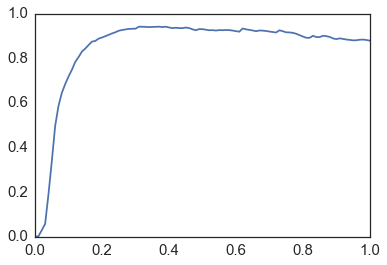

In [7]:
dq = 0.01
comp_q = np.arange(0, 1+dq, dq)
completeness = np.zeros_like(comp_q)
N = np.zeros_like(comp_q)
with h5py.File('data/Completeness.h5', 'r') as f:
    for star, grp in f.iteritems():
        if star not in binary_starlist and star not in multiple_starlist:
            star_completeness = np.zeros((len(grp.keys()), comp_q.size))
            i = 0
            for date, dgrp in grp.iteritems():
                df = Completeness.get_completeness(star.encode(), date.encode()).sort_values(by='q')
                fcn = spline(df.q, df.Detection_Rate)
                good = (comp_q < df.q.max()) & (comp_q > df.q.min())
                star_completeness[i, good] = fcn(comp_q[good])
                i += 1
                
            completeness += np.max(star_completeness, axis=0)
            N[good] += 1
            
# Set completeness = 0 at q = 0
completeness[0] = 0
N[0] = 1
plt.plot(comp_q, completeness/N)

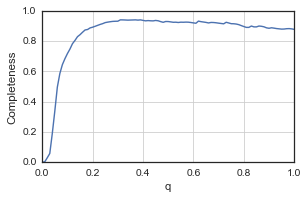

In [8]:
sns.set_context('paper', font_scale=1.3)
smooth_comp_fcn = UnivariateSpline(comp_q, completeness/N, s=0.01)

plt.figure(figsize=(5, 3))
plt.plot(comp_q, completeness/N)
#plt.plot(comp_q, smooth_comp_fcn(comp_q))
plt.xlabel('q')
plt.ylabel('Completeness')
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.grid()
plt.savefig('Figures/SurveyCompleteness.pdf')
plt.savefig('Figures/SurveyCompleteness.png')

# Fit a histogram:

Use the mass-ratio samples and the formalism presented in the paper to fit the data to a histogram. This code accounts for both completeness effects and malmquist bias:

In [9]:
import MassRatioDistribution
bins = np.linspace(0, 1, 8)
comp_fcn = spline(comp_q, completeness / N)
class MyFitter(MassRatioDistribution.SmoothHistFitter):
    def __init__(self, *args, **kwargs):
        super(MyFitter, self).__init__(*args, **kwargs)
        self.malm_pars = np.array([-0.02042249,  0.04079731, -0.0227729 ,  0.01252475, -0.00095515, 0.00712293])
        self.malm_integrals = np.array([self._integrate_malmquist(self.malm_pars[::-1], q0, q1) for 
                                        (q0, q1) in zip(self.bin_edges[:-1], self.bin_edges[1:])])
        self.malm_fcn = np.poly1d(self.malm_pars)
        
    def _integrate_malmquist(self, malm_pars, q0, q1):
        """ Integrate the malmquist-correction factor from q0 --> q1
        """
        return np.sum([p/(i+1.0)*(q1**(i+1.0) - q0**(i+1.0)) for i, p in enumerate(malm_pars)])
    
    def censoring_fcn(self, q):
        return comp_fcn(q)
    
    def lnlike(self, pars):
        # Pull theta out of pars
        theta = pars[:self.Nbins]

        # Generate the inner summation
        gamma = np.ones_like(self.bin_idx) * np.nan
        good = (self.bin_idx < self.Nbins) & (self.bin_idx >= 0)  # nans in q get put in nonexistent bins
        gamma[good] = self.Nobs * self.censoring_fcn(self.qvals[good]) * theta[self.bin_idx[good]]
        
        # Malmquist-correct
        gamma *= self.malm_fcn(self.qvals) / np.sum(theta * self.malm_integrals)

        # Calculate the integral
        I = self._integral_fcn(theta)

        # Generate the log-likelihood
        summation = np.nanmean(gamma, axis=1)
        ll = -I + np.nansum(np.log(summation))
        return ll
    
    def mnest_prior(self, cube, ndim, nparams):
        # Sample the bins uniformly, making sure they sum to 1
        for i in range(self.Nbins):
            cube[i] *= 10
        norm = np.sum(cube[:self.Nbins] * self.bin_widths)
        for i in range(self.Nbins):
            cube[i] /= norm
        
        # Sample the gaussian process hyperparameters uniformly
        cube[self.Nbins] = cube[self.Nbins] * 40 - 15
        cube[self.Nbins + 1] = cube[self.Nbins + 1] * 40 - 20
        cube[self.Nbins + 2] = cube[self.Nbins + 2] * 7 - 2
        cube[self.Nbins + 3] = cube[self.Nbins + 3] * 30 - 15
        return
    
shf = MyFitter(q, bin_edges=bins)

In [10]:
shf.smoothing = 10.0 # The default value is 6 for this dataset; this makes the smoothing prior somewhat less important

In [11]:
shf.fit_multinest(basename='MCMC_Samples/Fitters/HistFitter/RealData_malmquist', overwrite=False)

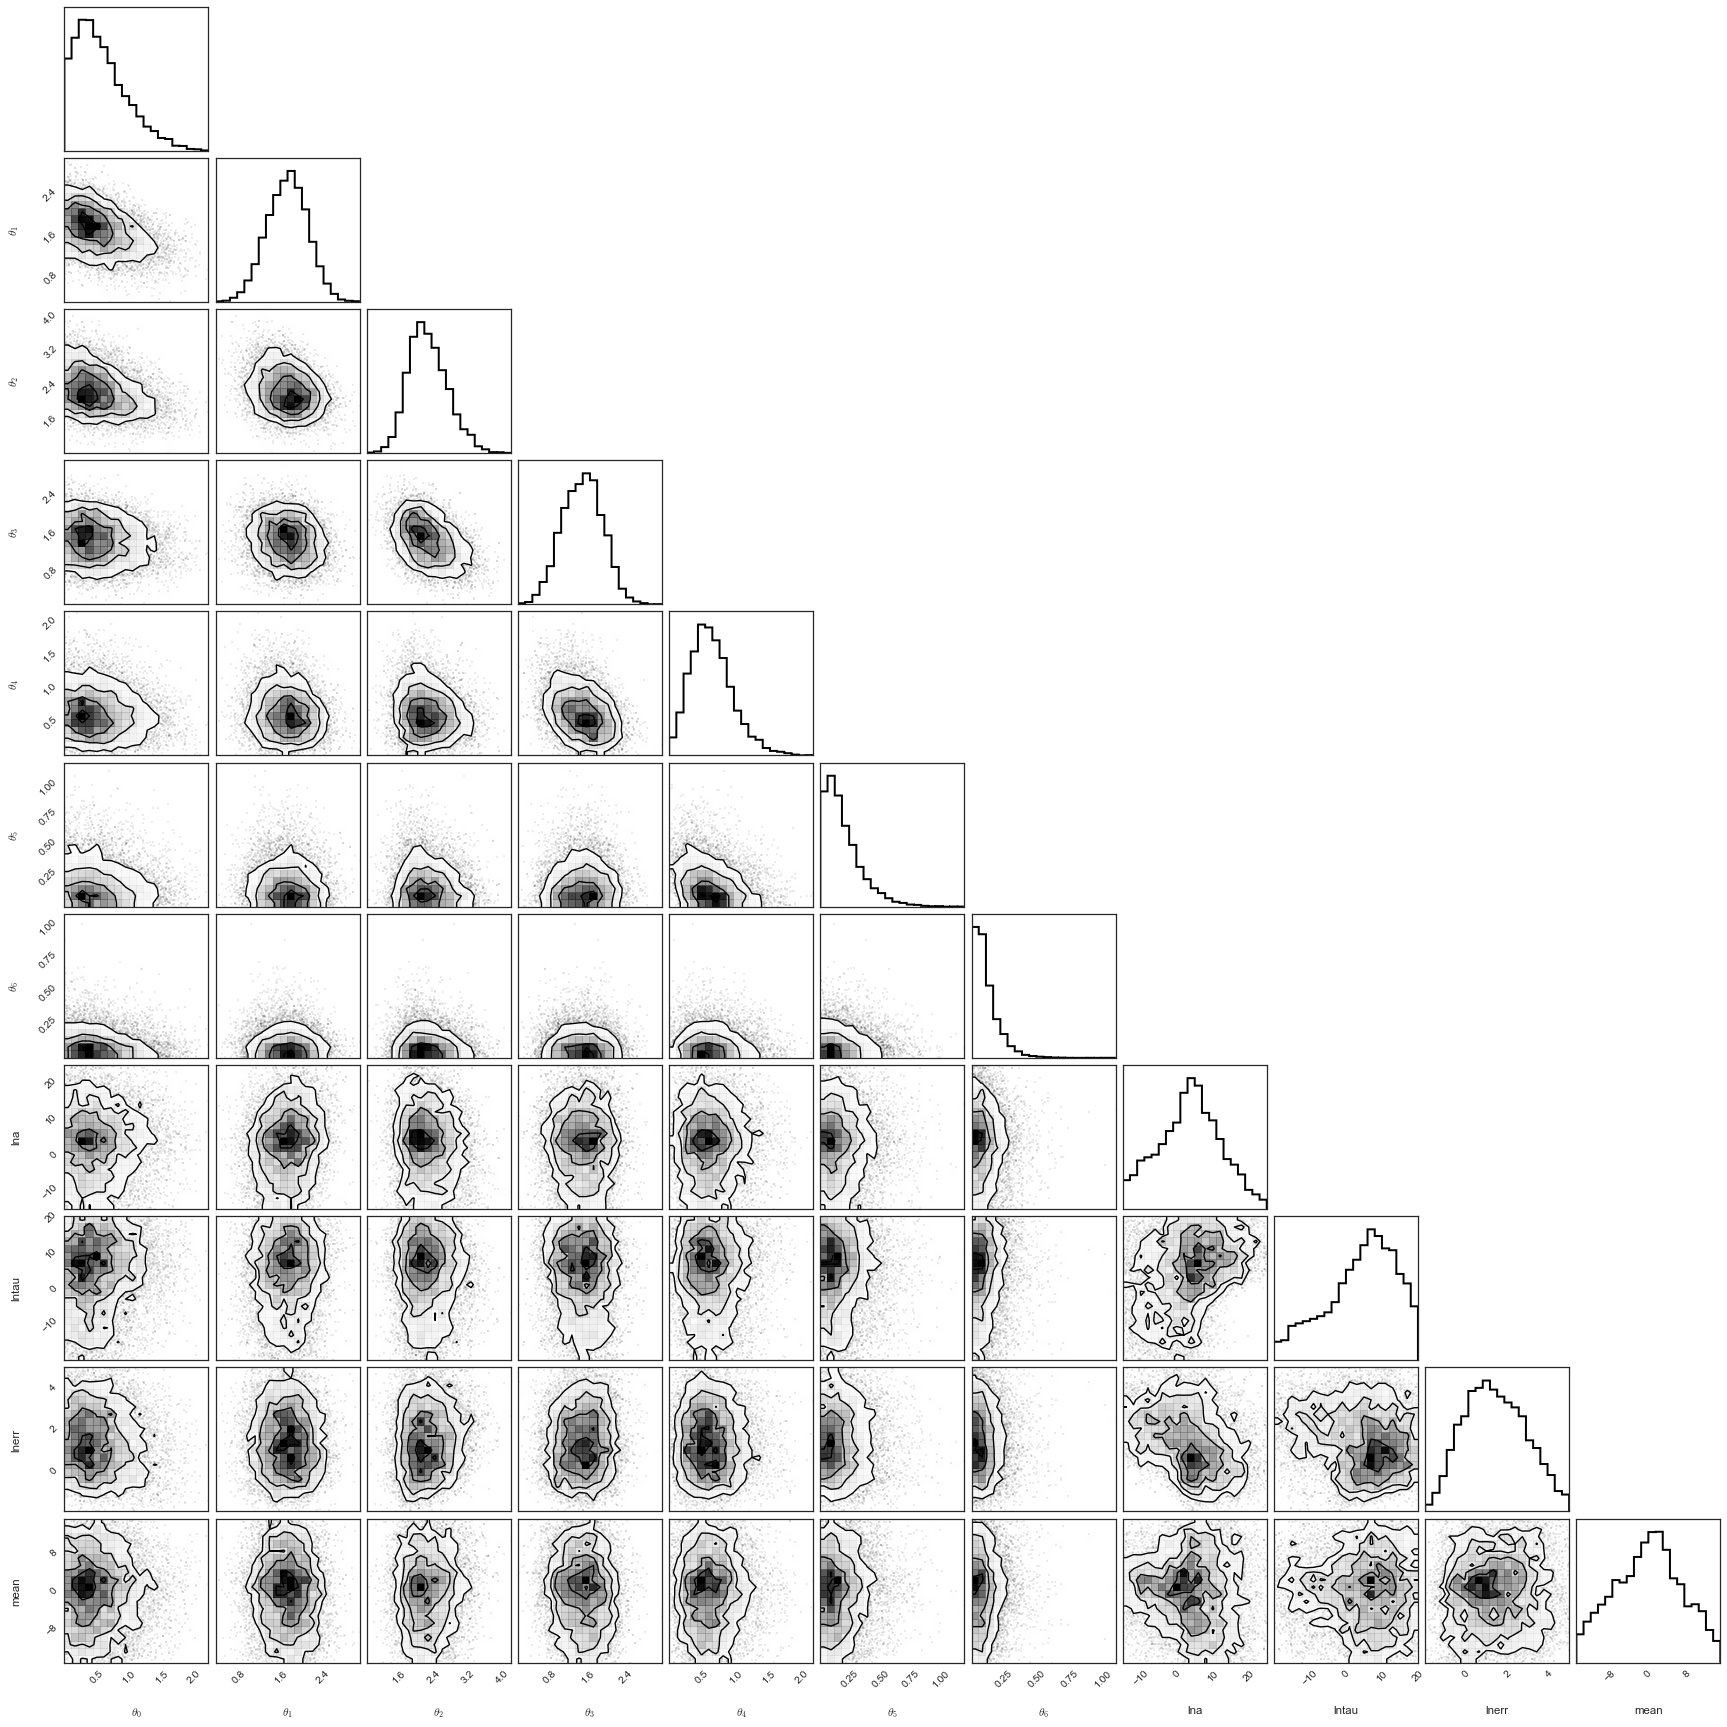

In [12]:
shf.triangle(hist_kwargs=dict(lw=2))

In [13]:
shf.samples.describe()

,$\theta_0$,$\theta_1$,$\theta_2$,$\theta_3$,$\theta_4$,$\theta_5$,$\theta_6$,lna,lnerr,lnprob,lntau,mean
count,8490.000000,8490.000000,8490.000000,8490.000000,8490.000000,8490.000000,8490.000000,8490.000000,8490.000000,8490.000000,8490.000000,8490.000000
mean,0.575341,1.716853,2.275635,1.486688,0.643427,0.191556,0.110498,3.613462,1.407934,148.436651,4.220880,-0.063718
std,0.394529,0.384668,0.455568,0.414032,0.318041,0.154075,0.094812,8.500235,1.464531,2.369647,9.425178,6.890030
min,0.000143,0.346186,0.831456,0.141751,0.000543,0.000012,0.000054,-14.990340,-1.999017,134.680194,-19.990969,-14.997962
25%,0.271012,1.452610,1.950496,1.189683,0.413497,0.079335,0.043666,-2.229744,0.294002,147.024584,-1.661682,-5.207813
50%,0.500539,1.727468,2.229129,1.496860,0.609058,0.153378,0.086174,3.904384,1.303401,148.772842,5.735820,0.208300
75%,0.802779,1.981347,2.569603,1.775799,0.828364,0.262860,0.149946,9.338237,2.474666,150.172511,11.508181,4.719913
max,2.213314,3.096213,4.209565,3.150435,2.163706,1.195980,1.095527,24.973240,4.993676,152.984452,19.995238,14.994716


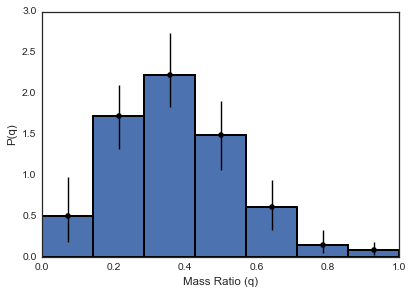

In [14]:
l, m, h = np.array([np.percentile(shf.samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
plt.bar(left=bins[:-1], width=shf.bin_widths, height=m, yerr=(m-l, h-m), label='DFM Histogram', fill=True, lw=2, ecolor='k')
plt.plot(shf.bin_centers, m, 'ko')
plt.xlabel('Mass Ratio (q)')
plt.ylabel('P(q)')

# Fit the data to a variety of distributions:

In [15]:
from kglib import fitters
from scipy.integrate import quad, romberg, fixed_quad, quadrature
from scipy.special import erf
from scipy.optimize import minimize, minimize_scalar

def get_lognormal_pars(mode, width):
    
    sigma = width
    mu = np.log(mode) + sigma**2
    return mu, sigma

class DistFitter(fitters.Bayesian_LS):
    def __init__(self, qvals):
        self.qvals = qvals
        self.lnq = np.log(qvals)
        self.completeness = self.completeness_fcn(self.qvals)
        self.Nobs = self.qvals.shape[0]
        self.setup_params()
        
        self.malm_pars = np.array([-0.02042249,  0.04079731, -0.0227729 ,  0.01252475, -0.00095515, 0.00712293])
        self.malm_fcn = np.poly1d(self.malm_pars)
    
    def completeness_fcn(self, q):
        return smooth_comp_fcn(q)
    
    def model(self, q, lnq, pars, malmcorr=True, use_cached_malmint=False):
        mu, sigma = pars
        A = 2.0 / (1 - erf(mu / (sigma * np.sqrt(2.0))))
        retval = A / (q * np.sqrt(2*np.pi*sigma**2)) * np.exp(-0.5 * (lnq - mu)**2 / sigma**2)
        
        # Malmquist-correct:
        if malmcorr:
            retval *= self.malm_fcn(q) / self._malmquist_integral(pars, use_cached=use_cached_malmint)
        return retval
    
    def setup_params(self):
        self.n_params = 2
        self.param_names = [r'$\mu$', r'$\sigma$']
    
    def _integrand(self, q, pars):
        return self.model(q, np.log(q), pars, use_cached_malmint=True) * self.completeness_fcn(q)
    
    def integral_fcn(self, pars):
        retval = quad(self._integrand, a=0, b=1.0, args=pars, maxp1=1000, limit=1000, limlst=1000)
        return retval[0] * self.Nobs
    
    def lnlike(self, pars):
        # Calculate gamma
        gamma = self.completeness * self.model(self.qvals, self.lnq, pars) * self.Nobs
        
        # Make the inner summation
        summand = np.nanmean(gamma, axis=1)
        summation = np.nansum(np.log(summand))
        
        return summation - self.integral_fcn(pars)
    
    def guess_fit_parameters(self, mode=0.4, width=0.3):
        mean, sigma = get_lognormal_pars(mode, width)
        def errfcn(p):
            return -self.lnlike(p)
        
        out = minimize(errfcn, (mean, sigma))
        mean, sigma = out.x
        return mean, sigma
    
    def mnest_prior(self, cube, ndim, nparams):
        # Sample the mean from -3 to 0 
        cube[0] = cube[0] * 3 - 3
        
        # Sample the width from 0.05 to 1
        cube[1] = cube[1] * 0.95 + 0.05
        return
    
    def predict(self, x, N=100, highest=False, malmcorr=False):
        """
        predict the y value for the given x values. Use the N most probable MCMC chains if highest=False,
        otherwise use the first N chains.
        """
        if self.samples is None:
            logging.warn('Need to run the fit method before predict!')
            return

        # Find the N best walkers
        if N == 'all':
            N = self.samples.shape[0]
        else:
            N = min(N, self.samples.shape[0])

        if highest:
            samples = self.samples.sort('lnprob', ascending=False)[:N]
        else:
            indices = np.random.randint(0, self.samples.shape[0], N)
            samples = self.samples.ix[indices]
        
        pars = samples[self.param_names].as_matrix()
        y = np.array([self.model(x, np.log(x), p, malmcorr=malmcorr) for p in pars])
        return y
    
    
    def _malmquist_integral(self, pars, use_cached=False):
        if use_cached:
            return self._malmquist_integral_cache
        else:
            def fcn(q):
                return self.model(q, np.log(q), pars, malmcorr=False) * self.malm_fcn(q)

            out = quad(fcn, a=0, b=1, maxp1=1000, limit=1000, limlst=1000)
            if out[1] / out[0] < 1e-4:
                self._malmquist_integral_cache = out[0]
                return out[0]
            print(pars)
            print(out)
            raise ValueError('Error on integration too large!')

    
class GaussianFitter(DistFitter):
    def model(self, q, lnq, pars, malmcorr=True, use_cached_malmint=False):
        mu, sigma = pars
        A = 2.0 / (erf(mu / (sigma * np.sqrt(2))) - erf((mu-1) / (sigma * np.sqrt(2))))
        retval = A / (np.sqrt(2*np.pi*sigma**2)) * np.exp(-0.5 * (q - mu)**2 / sigma**2)
        
        # Malmquist-correct:
        if malmcorr:
            retval *= self.malm_fcn(q) / self._malmquist_integral(pars, use_cached=use_cached_malmint)
        return retval
    
    def guess_fit_parameters(self, mode=0.4, width=0.3):
        def errfcn(p):
            retval = -self.lnlike(p)
            if np.isinf(retval):
                retval = 9e9
            return retval
        
        out = minimize(errfcn, (mode, width/2.0), bounds=((0, 1), (0.01, 1)))
        mean, sigma = out.x
        return mean, sigma
    
    def mnest_prior(self, cube, ndim, nparams):
        # Sample the mean from 0 to 1 
        cube[0] = cube[0] * 1.0
        
        # Sample the width from 0.01 to 3
        cube[1] = cube[1] * 3 + 0.01
        return
    
    
class PowerLawFitter(DistFitter):
    def setup_params(self):
        self.n_params = 1
        self.param_names = [r'$\gamma$',]
        
    def model(self, q, lnq, pars, malmcorr=True, use_cached_malmint=False):
        try:
            gamma = pars[0]
        except (TypeError, IndexError):
            gamma = pars
        #A = 2.0 / (erf(mu / (sigma * np.sqrt(2))) - erf((mu-1) / (sigma * np.sqrt(2))))
        #retval = A / (np.sqrt(2*np.pi*sigma**2)) * np.exp(-0.5 * (q - mu)**2 / sigma**2)
        retval = (1-gamma) * q**(-gamma)
        
        # Malmquist-correct:
        if malmcorr:
            retval *= self.malm_fcn(q) / self._malmquist_integral(pars, use_cached=use_cached_malmint)
        return retval
    
    def guess_fit_parameters(self, gamma=0):
        def errfcn(p):
            retval = -self.lnlike(p)
            if np.isinf(retval):
                retval = 9e9
            print(p, retval)
            return retval
        
        #out = minimize(errfcn, (gamma,), bounds=((-1, 1),))
        out = minimize_scalar(errfcn, bracket=(-0.5, 0.5), bounds=(-1, 1))
        gamma = out.x
        return gamma
    
    def mnest_prior(self, cube, ndim, nparams):
        # Sample the gamma from -1 to 1 
        cube[0] = cube[0] * 2.0 - 1.0
        
        return
    
    
from scipy import special
class BetaFitter(DistFitter):
    def setup_params(self):
        self.n_params = 2
        self.param_names = [r'$\alpha$', r'$\beta$']
    
    def model(self, q, lnq, pars, malmcorr=True, use_cached_malmint=False):
        alpha, beta = pars
        A = special.gamma(alpha+beta) / (special.gamma(alpha) * special.gamma(beta))
        retval = A * q**(alpha-1) * (1-q)**(beta-1)
        
        # Malmquist-correct:
        if malmcorr:
            retval *= self.malm_fcn(q) / self._malmquist_integral(pars, use_cached=use_cached_malmint)
        return retval
    
    def guess_fit_parameters(self, alpha=5, beta=8):
        def errfcn(p):
            retval = -self.lnlike(p)
            #print(p, retval)
            if np.isinf(retval):
                retval = 9e9
            return retval
        
        out = minimize(errfcn, (alpha, beta), bounds=((0, 25), (0, 25)))
        alpha, beta = out.x
        return alpha, beta
    
    def mnest_prior(self, cube, ndim, nparams):
        # Sample alpha from 0 to 25
        cube[0] = cube[0] * 25
        
        # Sample beta from 0 to 25
        cube[1] = cube[1] * 25
        return
    
    
class IMFFitter(DistFitter):
    def __init__(self, *args, **kwargs):
        super(IMFFitter, self).__init__(*args, **kwargs)
        import dill
        with open('Kroupa_MRD.dill', 'r') as infile:
            self.kroupa_mrd = dill.load(infile)
        
    def setup_params(self):
        self.n_params = 0
        self.param_names = []
    
    def model(self, q, lnq, pars, malmcorr=True, use_cached_malmint=False):
        if isinstance(q, np.ndarray) and len(q.shape) > 1: 
            retval = np.array([self.kroupa_mrd(q[i]) for i in range(q.shape[0])])
        else:
            retval = self.kroupa_mrd(q)
        
        # Malmquist-correct:
        if malmcorr:
            retval *= self.malm_fcn(q) / self._malmquist_integral(pars, use_cached=use_cached_malmint)
        return retval

## Normal distribution

In [16]:
# Helper Function
def fit_data(function='gaussian', *args, **kwargs):
    if function.lower() == 'gaussian':
        df = GaussianFitter(q)
    elif function.lower() == 'lognormal':
        df = DistFitter(q)
    elif function.lower() == 'power':
        df = PowerLawFitter(q)
    elif function.lower() == 'beta':
        df = BetaFitter(q)
    
    df.fit_multinest(*args, **kwargs)
    df.triangle(hist_kwargs=dict(lw=2))
    return df

  analysing data from MCMC_Samples/Fitters/GaussianFitter/RealData_malmquist.txt
log evidence = 146.9518 +/- 0.01211


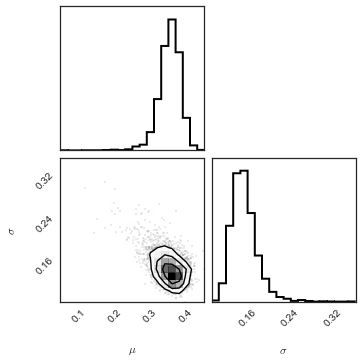

In [17]:
df = fit_data(function='gaussian',
              basename='MCMC_Samples/Fitters/GaussianFitter/RealData_malmquist', overwrite=False)
print('log evidence = {:.4f} +/- {:.5f}'.format(*df.evidence))

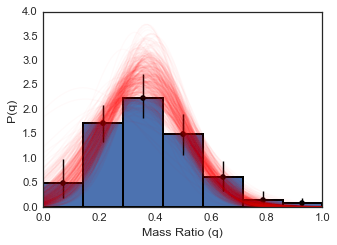

In [18]:
sns.set_context('paper', font_scale=1.4)

fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))

l, m, h = np.array([np.percentile(shf.samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
ax.bar(left=bins[:-1], width=shf.bin_widths, height=m, yerr=(m-l, h-m), label='DFM Histogram', fill=True, lw=2, ecolor='k')
ax.plot(shf.bin_centers, m, 'ko')
ax.set_xlabel('Mass Ratio (q)')
ax.set_ylabel('P(q)')

qvals = np.linspace(0, 1, 100)
#plt.plot(qvals, df.model(qvals, np.log(qvals), (mean, sigma)), 'r-')
df.plot_samples(qvals, N=500, ax=ax, color='red', alpha=0.02)

ax.set_ylim((0, 4.0))
fig.savefig('Figures/MRD_normal.pdf')
fig.savefig('Figures/MRD_normal.png')

In [19]:
df.samples.describe()

,$\mu$,$\sigma$,lnprob
count,3723.000000,3723.000000,3723.000000
mean,0.355042,0.153472,152.721248
std,0.031015,0.024197,1.192819
min,0.047989,0.092017,142.337809
25%,0.338106,0.137115,152.331603
50%,0.358354,0.150199,153.102457
75%,0.375059,0.166004,153.534984
max,0.452557,0.363029,153.847549


## Power law

  analysing data from MCMC_Samples/Fitters/PowerLawFitter/RealData_malmquist.txt
log evidence = 126.5944 +/- 0.01074


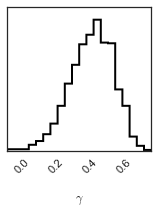

In [20]:
df = fit_data(function='power',
              basename='MCMC_Samples/Fitters/PowerLawFitter/RealData_malmquist', overwrite=False)
print('log evidence = {:.4f} +/- {:.5f}'.format(*df.evidence))

In [21]:
l, m, h = np.percentile(df.samples['$\gamma$'].values, [16, 50, 84])
print(m, h-m, m-l)
print(df.samples.loc[np.argmax(df.samples.lnprob), '$\gamma$'])
df.samples.describe()

0.419673834651 0.1153457398 0.136304466305
0.439382316162


,$\gamma$,lnprob
count,2792.000000,2792.000000
mean,0.409647,127.953016
std,0.126216,0.688547
min,-0.083854,121.849362
25%,0.327279,127.766850
50%,0.419674,128.213483
75%,0.502955,128.401116
max,0.757474,128.455377


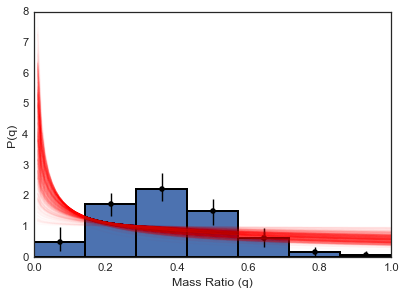

In [22]:
l, m, h = np.array([np.percentile(shf.samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
plt.bar(left=bins[:-1], width=shf.bin_widths, height=m, yerr=(m-l, h-m), label='DFM Histogram', fill=True, lw=2, ecolor='k')
plt.plot(shf.bin_centers, m, 'ko')
plt.xlabel('Mass Ratio (q)')
plt.ylabel('P(q)')

#plt.plot(qvals, df.model(qvals, np.log(qvals), (mean, sigma)), 'r-')
df.plot_samples(qvals, N=500, ax=plt.gca(), color='red', alpha=0.02)
plt.savefig('Figures/MRD_powerlaw.pdf')
plt.savefig('Figures/MRD_powerlaw.png')

  analysing data from MCMC_Samples/Fitters/BetaFitter/RealData_malmquist.txt
log evidence = 149.4143 +/- 0.01114


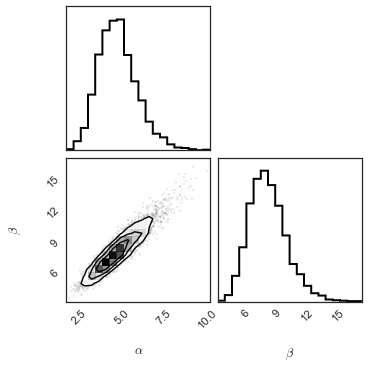

In [23]:
df = fit_data(function='beta',
              basename='MCMC_Samples/Fitters/BetaFitter/RealData_malmquist', overwrite=False)
print('log evidence = {:.4f} +/- {:.5f}'.format(*df.evidence))

In [24]:
alpha = df.samples[r'$\alpha$']
beta = df.samples[r'$\beta$']
df.samples['Max'] = (alpha-2) / (beta-2) / (1 + (alpha-2) / (beta-2))
df.samples.describe(percentiles=[0.16, 0.50, 0.84])

,$\alpha$,$\beta$,lnprob,Max
count,3526.000000,3526.000000,3526.000000,3526.000000
mean,4.782220,8.160565,153.314164,0.302570
std,1.141322,1.844585,1.034078,0.044715
min,1.757560,3.212096,146.499710,-0.250027
16%,3.682628,6.380314,152.430758,0.265081
50%,4.690371,7.981621,153.643319,0.307900
84%,5.864665,9.942838,154.162522,0.341954
max,10.204824,17.302586,154.341626,0.412352


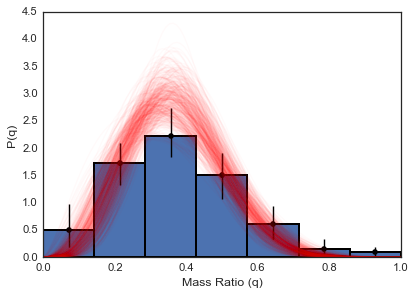

In [25]:
l, m, h = np.array([np.percentile(shf.samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
plt.bar(left=bins[:-1], width=shf.bin_widths, height=m, yerr=(m-l, h-m), label='DFM Histogram', fill=True, lw=2, ecolor='k')
plt.plot(shf.bin_centers, m, 'ko')
plt.xlabel('Mass Ratio (q)')
plt.ylabel('P(q)')

#plt.plot(qvals, df.model(qvals, np.log(qvals), (mean, sigma)), 'r-')
df.plot_samples(qvals, N=500, ax=plt.gca(), color='red', alpha=0.02)
plt.savefig('Figures/MRD_beta.pdf')
plt.savefig('Figures/MRD_beta.png')

In [62]:
# Compare to Kroupa IMF:
df = IMFFitter(q)
ll = df.lnlike([])
print(ll)  # This is the evidence for the Kroupa IMF (compare to the evidences quoted above)

102.18251804


# Everything Plot
Make a plot similar to the beta distribution one, but also overplot the best-fit power law and the Kroupa IMF fit.

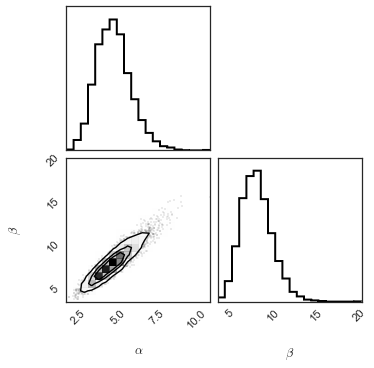

In [26]:
best_gamma = 0.439382316162
imf_fitter = IMFFitter(q)

beta_fitter = fit_data(function='beta',
                        basename='MCMC_Samples/Fitters/BetaFitter/RealData_malmquist', overwrite=False)

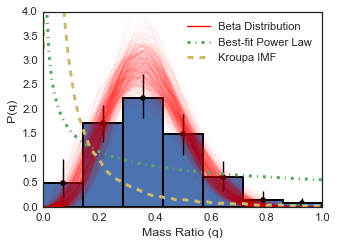

In [28]:
sns.set_context('paper', font_scale=1.4)
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))

l, m, h = np.array([np.percentile(shf.samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
ax.bar(left=bins[:-1], width=shf.bin_widths, height=m, yerr=(m-l, h-m), fill=True, lw=2, ecolor='k')
ax.plot(shf.bin_centers, m, 'ko')
ax.set_xlabel('Mass Ratio (q)')
ax.set_ylabel('P(q)')

colors = sns.color_palette()
beta_fitter.plot_samples(qvals, N=500, ax=ax, color='red', alpha=0.02)
ax.plot([], [], 'r-', label='Beta Distribution')

ax.plot(qvals, (1-best_gamma) * qvals**(-best_gamma), label='Best-fit Power Law', lw=3, color=colors[1], ls='-.')
ax.plot(qvals, imf_fitter.kroupa_mrd(qvals), label='Kroupa IMF', lw=3, color=colors[4], ls='--')

leg = ax.legend(loc='best', fancybox=True)
ax.set_ylim((0, 4.0))
plt.savefig('Figures/MRD_total.pdf')
plt.savefig('Figures/MRD_total.png')

# How unlikely is the difference between my results and VAST?
Sample from the q distributions for my data, and compare to 19 stars in the close-by VAST sample. I will only include stars from my sample with mean $q > 0.15$, above which the completeness is roughly constant.

In [29]:
import scipy.stats
vast_qvals = np.array([0.32, 0.18, 0.58, 0.57, 0.44, 0.49, 0.25, 0.74, 
                       0.99, 0.23, 0.18, 0.71, 0.44, 0.39, 0.99, 0.83, 
                       1, 0.27, 0.72])

In [30]:
good_idx = np.nanmean(q, axis=1) > 0.15
high_q = q[good_idx]
def get_ks_stat():
    N = high_q.shape[0]
    my_qvals = np.zeros(N)
    for i in range(N):
        done = False
        while not done:
            done = True
            q = np.random.choice(high_q[i])
            if np.isnan(q):
                done = False
        my_qvals[i] = q
    
    #return scipy.stats.ks_2samp(vast_qvals, my_qvals)
    return scipy.stats.anderson_ksamp((get_vast_q(), my_qvals))

def get_vast_q(err=0.05):
    """ Sample VAST q by assuming uncertainties of 0.05"""
    a, b = (-vast_qvals) / err, (1-vast_qvals) / err
    return np.array([scipy.stats.truncnorm.rvs(a[i], b[i], loc=vast_qvals[i], scale=err) for i in range(len(vast_qvals))])

In [32]:
N = 100000
p_value = np.zeros(N)
for i in range(N):
    ks, _, p = get_ks_stat()
    p_value[i] = p

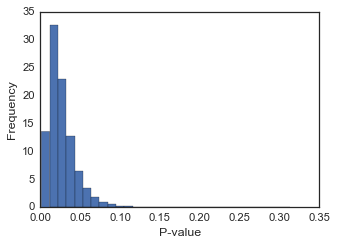

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
bins = 30
ax.hist(p_value, bins=bins, normed=True)

ax.set_xlabel('P-value')
ax.set_ylabel('Frequency')
fig.savefig('Figures/VAST_pval.pdf')
fig.savefig('Figures/VAST_pval.png')

In [34]:
# Summarize the p-value
l, m, h = np.percentile(p_value, [16, 50, 84])
print('p = {:.3f} +{:.3f} / -{:.3f}'.format(m, h-m, m-l))

p = 0.023 +0.019 / -0.010
